In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp
import pandas as pd
from skimage.io import imread
from sklearn.neighbors import KNeighborsClassifier

## 2. Transformations on images

### Problem 2.2

In [2]:
def create_trans_matrix(c_1, c_2, t_1, t_2, theta, s):

    T_t = np.array([[1, 0, t_1],
                    [0, 1, t_2],
                    [0, 0, 1]])

    T_c = np.array([[1, 0, c_1],
                    [0, 1, c_2],
                    [0, 0, 1]])

    # use -theta to get counterclockwise rotation in image
    R = np.array([[np.cos(-theta), -np.sin(-theta), 0],
                [np.sin(-theta), np.cos(-theta), 0],
                [0, 0, 1]])
    
    S = np.array([[s, 0, 0],
                  [0, s, 0],
                  [0, 0, 1]])
    
    trans_matrix = T_t @ T_c @ R @ S @ np.linalg.inv(T_c)
    return trans_matrix

def perform_trans(image, c_1, c_2, t_1, t_2, theta, s):

    trans_mat = create_trans_matrix(c_1=c_1, c_2=c_2, t_1=t_1, t_2=t_2, theta=theta, s=s)
    image_trans = warp(image, np.linalg.inv(trans_mat), order=0)  # nearest neighbor

    return image_trans

In [3]:
N_x = 151
N_y = 171

square = np.zeros((N_y, N_x))
square[70:-70, 60:-60] = 1

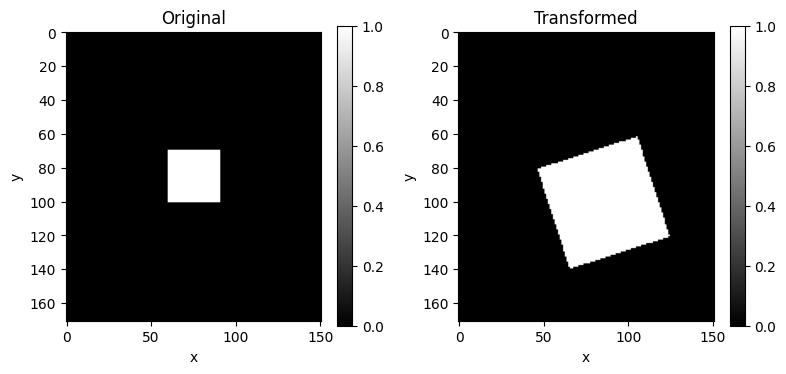

In [4]:
square_trans = perform_trans(square, c_1=75, c_2=85, t_1=10.4, t_2=15.7, theta=np.pi/10, s=2)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(square, cmap="gray")
plt.colorbar(shrink=0.85)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(square_trans, cmap="gray")
plt.colorbar(shrink=0.85)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Transformed")

plt.tight_layout()

## 3. Transformations on point clouds

### Problem 3.1

In [5]:
def loadData(filename):
    """Read the data in filename and returns a tuple with first element
    being an 261 x 32 array with the all the fly wings along the
    first axis and landmark coordinates along the second axis and
    second element being an array with class labels."""

    X = pd.read_csv(filename , usecols=list(range(2, 66))).values
    XL = pd.read_csv(filename, usecols=[1]).values.flatten()
    return X, XL

In [6]:
XTrain, XTrainL = loadData("BioSCAN_dataset_Train.csv")
XTest, XTestL = loadData("BioSCAN_dataset_Test.csv")

In [7]:
xy_test = np.zeros((XTest.shape[0], 2, int(XTest.shape[1]/2)))

for i in range(len(XTest)):
    xy_test[i, :, :] = XTest[i].reshape(-1, 2).T


xy_train = np.zeros((XTrain.shape[0], 2, int(XTrain.shape[1]/2)))

for i in range(len(XTrain)):
    xy_train[i, :, :] = XTrain[i].reshape(-1, 2).T

In [8]:
ref = xy_train[0]

ref_zeromean = np.empty_like(ref)
for i in range(ref.shape[1]):
    ref_zeromean[:, i] = ref[:, i] - np.mean(ref, axis=1)

In [9]:
def translation(coords, ref_coords):

    # compute means
    ref_mean = np.mean(ref_coords, axis=1)
    coord_mean = np.mean(coords, axis=1)

    # compute translation vector
    t = ref_mean - coord_mean  

    # add translation vector to each point
    coords_translated = np.empty_like(coords)
    for i in range(coords.shape[1]):
        coords_translated[:, i] = coords[:, i] + t
        
    return coords_translated


def scaling(coords, ref_coords):

    # construct scaling parameter
    numerator = 0
    denominator = 0
    for i in range(coords.shape[1]):
        numerator += coords[0, i] * ref_coords[0, i] + coords[1, i] * ref_coords[1, i]
        denominator += coords[0, i] * coords[0, i] + coords[1, i] * coords[1, i]

    s = numerator / denominator

    S = np.identity(coords.shape[0]) * s  # construct scaling matrix

    return S @ coords  # apply scaling


def rotation(coords, ref_coords):
    U, S, V_T = np.linalg.svd(coords@ref_coords.T)  # compute U and V
    R = V_T.T @ U.T  # construct rotation matrix
    return R @ coords  # apply rotation

In [10]:
def Procrustes_align(input_coords, reference):

    aligned_coords = np.empty_like(input_coords)  # initialize

    for i in range(len(input_coords)):  # apply transformations on each wing
        trans_coords_i = translation(input_coords[i], reference)
        scale_coords_i = scaling(trans_coords_i, reference)
        rot_coords_i = rotation(scale_coords_i, reference)

        aligned_coords[i, :, :] = rot_coords_i  # save data for current wing
    
    return aligned_coords

In [11]:
test_align = Procrustes_align(xy_test, ref_zeromean)
train_align = Procrustes_align(xy_train, ref_zeromean)

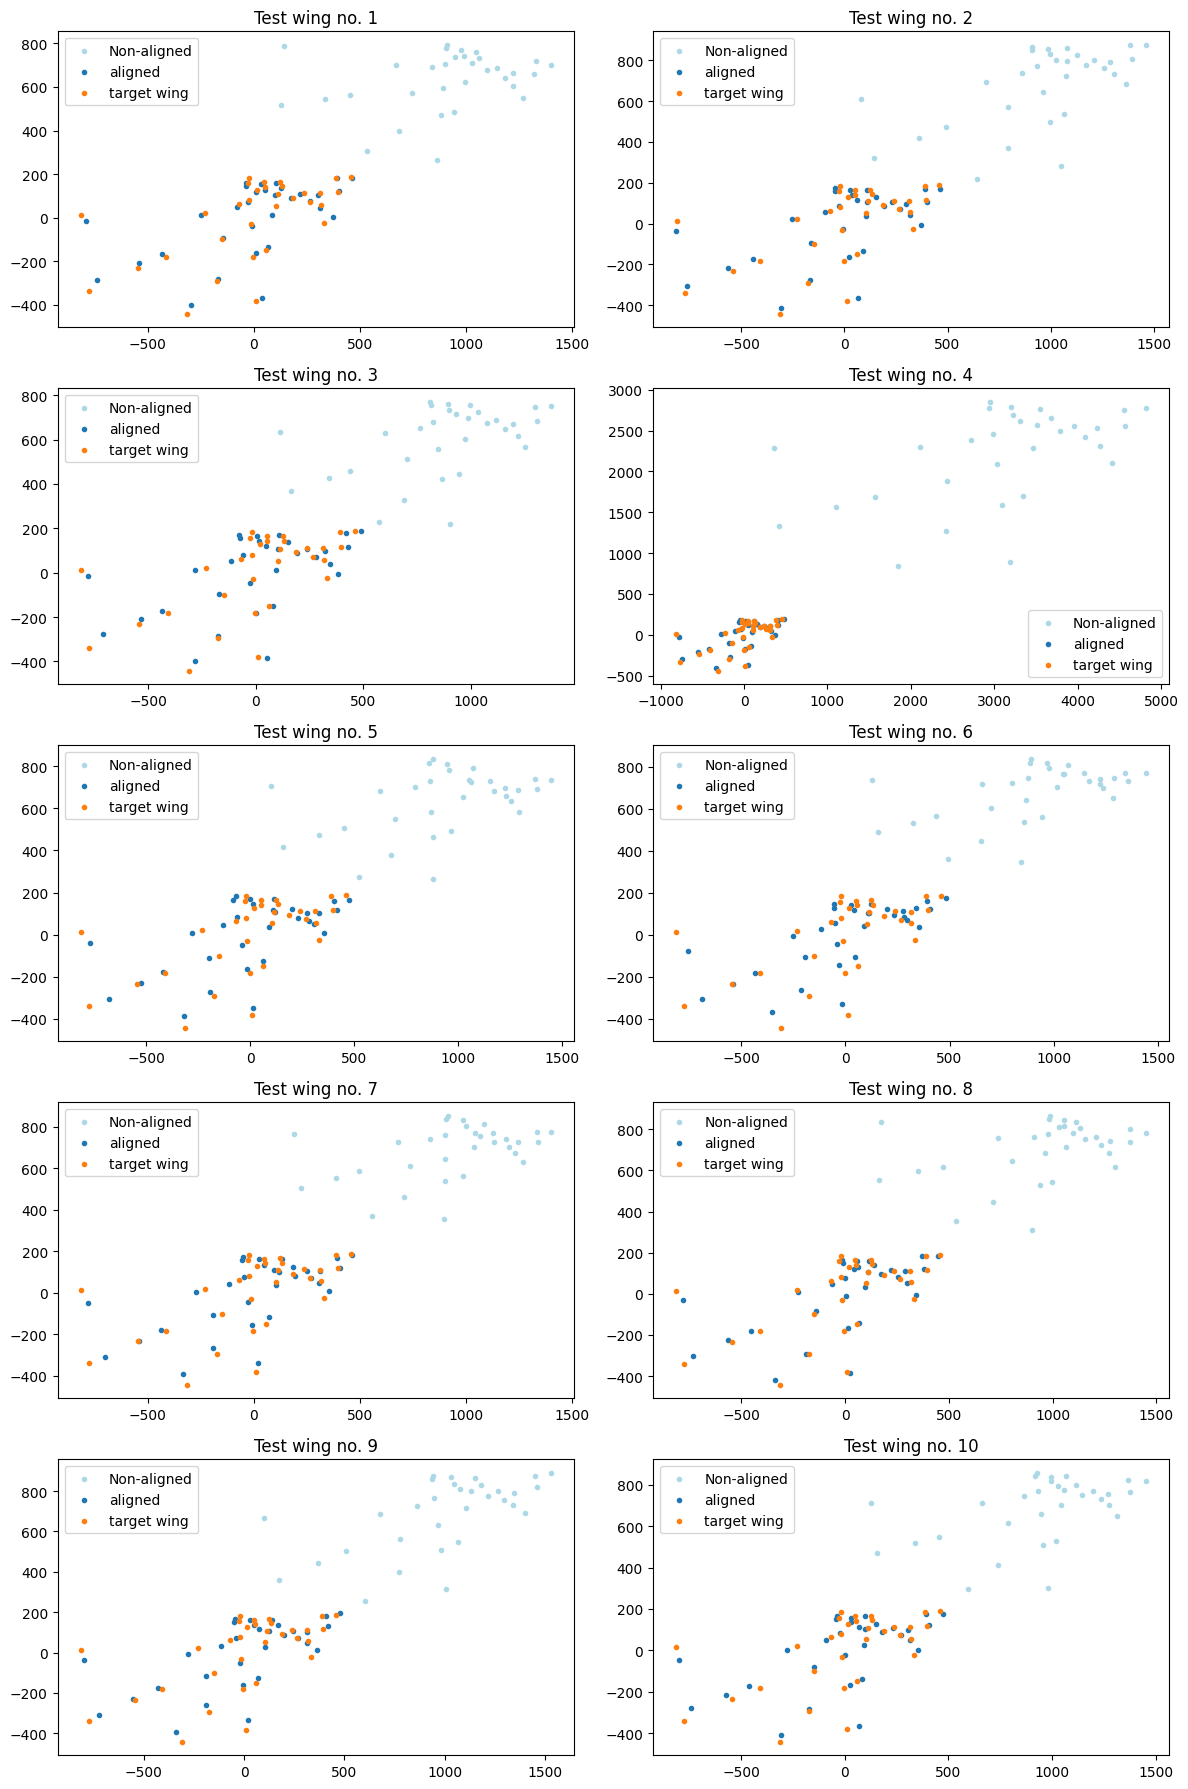

In [12]:
plt.figure(figsize=(12, 18))

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.scatter(xy_test[i, 0, :], xy_test[i, 1, :], marker=".", label="Non-aligned", c="lightblue")
    plt.scatter(test_align[i, 0, :], test_align[i, 1, :], marker=".", label="aligned")
    plt.scatter(ref_zeromean[0, :], ref_zeromean[1, :], marker=".", label="target wing")
    plt.title(f"Test wing no. {i+1}")
    plt.legend()

plt.tight_layout()

### Problem 3.2

In [13]:
# reshape aligned data

XTest_align = np.empty_like(XTest)
for i in range(len(test_align)):
    XTest_align[i] = test_align[i].T.reshape(-1)

XTrain_align = np.empty_like(XTrain)
for i in range(len(train_align)):
    XTrain_align[i] = train_align[i].T.reshape(-1)

In [14]:
# non-aligned data
knn = KNeighborsClassifier()
knn.fit(XTrain, XTrainL)
Pred_labels = knn.predict(XTest)
acc_non_align = np.mean(Pred_labels==XTestL)

In [15]:
# aligned data
knn = KNeighborsClassifier()
knn.fit(XTrain_align, XTrainL)
Pred_labels = knn.predict(XTest_align)
acc_align = np.mean(Pred_labels==XTestL)

In [16]:
print(f"For non-aligned wings: accuracy = {acc_non_align}")
print(f"For aligned wings: accuracy = {acc_align}")

For non-aligned wings: accuracy = 0.5063291139240507
For aligned wings: accuracy = 0.8607594936708861


## 4. Histogram based segmentation

### Problem 4.1

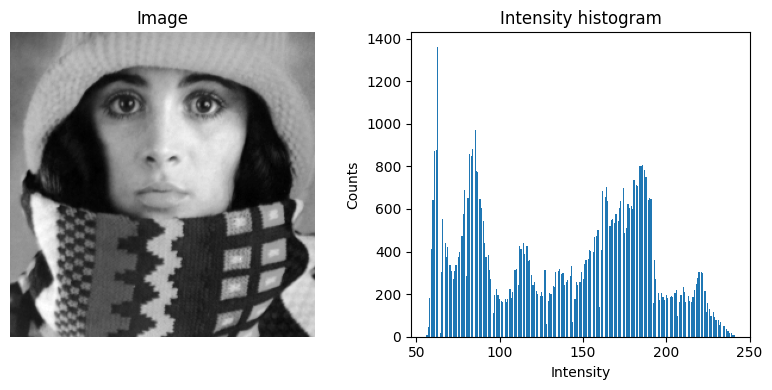

In [17]:
ex1 = imread("trui.png")

plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.imshow(ex1, cmap="gray")
plt.axis("off")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.hist(ex1.flatten(), bins=256)
plt.title("Intensity histogram")
plt.xlabel("Intensity")
plt.ylabel("Counts")

plt.tight_layout()

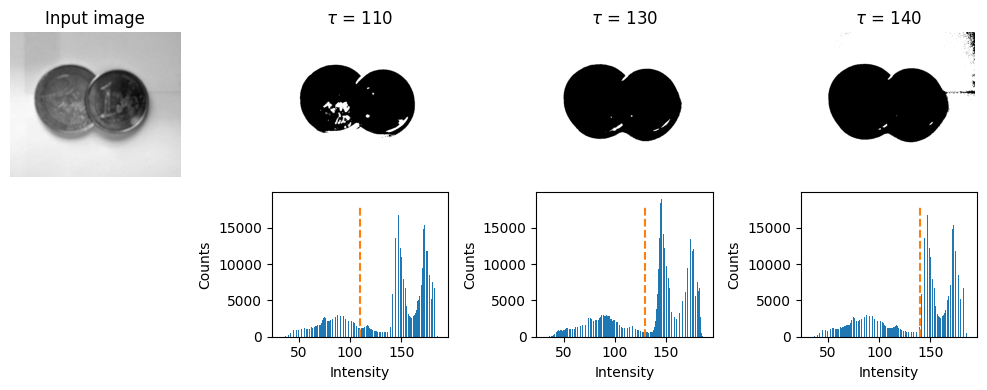

In [18]:
ex2 = imread("overlapping_euros.jpg")

plt.figure(figsize=(10, 4))
plt.subplot(2, 4, 1)
plt.imshow(ex2, cmap="gray")
plt.axis("off")
plt.title("Input image")

threshold = np.array([110, 130, 140])

for i, t in enumerate(threshold):
    binary_ex2 = np.where(ex2 <= t, 0, 1)
    plt.subplot(2, 4, i+2)
    plt.imshow(binary_ex2, cmap="gray")
    plt.axis("off")
    plt.title(fr"$\tau$ = {t}")

for i, t in enumerate(threshold):
    plt.subplot(2, 4, i+6)
    plt.hist(ex2.flatten(), bins=256)
    plt.plot((t, t), (0, 18000), "--", label=rf"$\tau$ = {t}")
    plt.xlabel("Intensity")
    plt.ylabel("Counts")

plt.tight_layout()

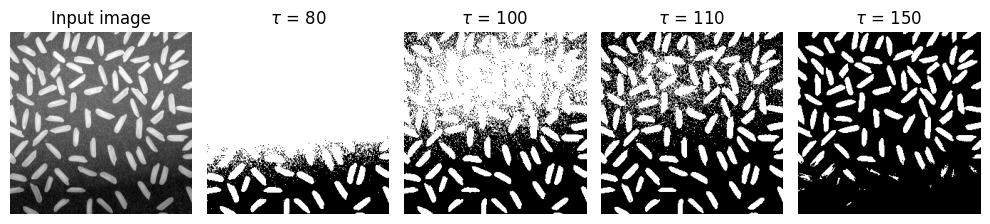

In [19]:
ex3 = imread("rice.png")

plt.figure(figsize=(10, 4))
plt.subplot(1, 5, 1)
plt.imshow(ex3, cmap="gray")
plt.axis("off")
plt.title("Input image")

threshold = np.array([80, 100, 110, 150])

for i, t in enumerate(threshold):
    binary_ex2 = np.where(ex3 <= t, 0, 1)
    plt.subplot(1, 5, i+2)
    plt.imshow(binary_ex2, cmap="gray")
    plt.axis("off")
    plt.title(fr"$\tau$ = {t}")

plt.tight_layout()